In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1、逻辑回归

在这部分练习中，你将构建一个逻辑回归模型预测一个学生是否会被大学录取。假设你是某个大学院系的管理人员，你打算根据申请人两次考试的成绩来判断他们被录取的可能性。你有可以用作逻辑回归训练集的以前申请者的历史数据。每个训练样本都包含历史申请人两次考试的成绩和最终的录取结果。

In [59]:
# 加载数据
data = pd.read_csv('ex2/ex2data1.txt', names=['exam1', 'exam2', 'admitted'])
data.head()

,exam1,exam2,admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


## 1.1 可视化数据

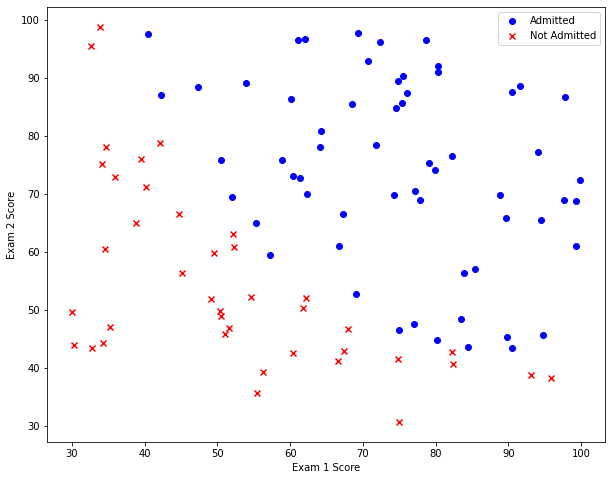

In [60]:
positive = data[data['admitted'] == 1]
negative = data[data['admitted'] == 0]

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(positive['exam1'], positive['exam2'], c='b', marker='o', label='Admitted')
ax.scatter(negative['exam1'], negative['exam2'], c='r', marker='x', label='Not Admitted')

ax.legend()
ax.set_xlabel('Exam 1 Score')
ax.set_ylabel('Exam 2 Score')
plt.show()

## 1.2 Sigmoid函数

In [61]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

让我们做一个快速的检查，来确保它可以工作

<function matplotlib.pyplot.show(close=None, block=None)>

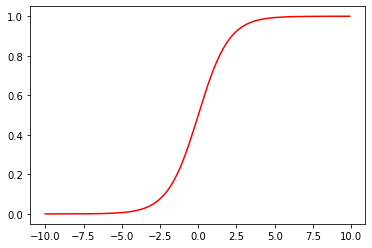

In [62]:
x1 = np.arange(-10, 10, 0.1)
plt.plot(x1, sigmoid(x1), c='r')
plt.show

fine!

## 1.3 Cost Function

In [63]:
def cost(theta, X, y):
    first = (-y) * np.log(sigmoid(X @ theta))
    second = (1 - y) * np.log(1 - sigmoid(X @ theta))
    
    return np.mean(first - second)

现在，我们要做一些设置，获取我们的训练集数据

In [64]:
if 'ones' not in data.columns:
    data.insert(0, 'ones', 1)

# 设置训练集和目标变量
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

theta = np.zeros(X.shape[1])

In [65]:
# 检查矩阵维度，确保一切良好
X.shape, theta.shape, y.shape

((100, 3), (3,), (100,))

In [66]:
cost(theta, X, y)

0.6931471805599453

## 1.4 Gradient

* 批量梯度下降
* 转化为向量化计算：$\frac{1}{m}X^T(Sigmoid(Xθ) - y)$

In [67]:
def gradient(theta, X, y):
    return (X.T @ (sigmoid(X @ theta) - y)) / len(X)

In [68]:
gradient(theta, X, y)

array([ -0.1       , -12.00921659, -11.26284221])

## 1.5 学习θ参数

注意，我们实际上没有在这个函数中执行梯度下降，我们仅仅在计算梯度。在练习中，一个称为“fminunc”的Octave函数是用来优化函数来计算成本和梯度参数。由于我们使用Python，我们可以用SciPy的“optimize”命名空间来做同样的事情。

这里我们使用的是高级优化算法，运行速度通常远远超过梯度下降。方便快捷。
只需传入cost函数，已经所求的变量theta，和梯度。cost函数定义变量时变量tehta要放在第一个，若cost函数只返回cost，则设置fprime=gradient。

In [69]:
import scipy.optimize as opt

result = opt.fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, y))
result

(array([-25.16131846,   0.20623159,   0.20147148]), 36, 0)

In [70]:
cost(result[0], X, y)

0.20349770158947528

## 1.6 评估逻辑回归

学习好了参数θ后，我们来用这个模型预测某个学生是否能被录取。

接下来，我们需要编写一个函数，用我们所学的参数theta来为数据集X输出预测。然后，我们可以使用这个函数来给我们的分类器的训练精度打分。

逻辑回归模型的假设函数：
$$h_θ(x) = \frac{1}{1+e^{-θ^TX}}$$

当$h_θ$大于等于0.5时，预测 y=1

当$h_θ$小于0.5时，预测 y=0 。

In [71]:
def predict(theta, X):
    predictions = sigmoid(X @ theta)
    return [1 if x >= 0.5 else 0 for x in predictions]

In [72]:
# 计算预测精度
final_theta = result[0]
predictions = predict(final_theta, X)
correct = [1 if a==b else 0 for (a, b) in zip(predictions, y)]
accuracy = sum(correct) / len(X)
accuracy

0.89

## 1.7 决策边界

X × θ = 0 (this is the line)

In [73]:
x1 = np.arange(130, step=0.1)
x2 = -(final_theta[0] + x1*final_theta[1]) / final_theta[2]

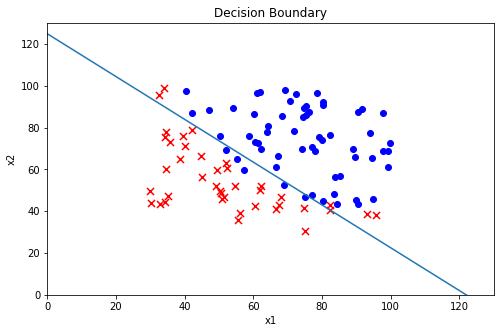

In [74]:
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(positive['exam1'], positive['exam2'], c='b', label='Admitted')
ax.scatter(negative['exam1'], negative['exam2'], s=50, c='r', marker='x', label='Not Admitted')
ax.plot(x1, x2)
ax.set_xlim(0, 130)
ax.set_ylim(0, 130)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_title('Decision Boundary')
plt.show()

# 2、正则化逻辑回归

在训练的第二部分，我们将要通过加入正则项提升逻辑回归算法。简而言之，正则化是成本函数中的一个术语，它使算法更倾向于“更简单”的模型（在这种情况下，模型将更小的系数）。这个理论助于减少过拟合，提高模型的泛化能力。这样，我们开始吧。

设想你是工厂的生产主管，你有一些芯片在两次测试中的测试结果。对于这两次测试，你想决定是否芯片要被接受或抛弃。为了帮助你做出艰难的决定，你拥有过去芯片的测试数据集，从其中你可以构建一个逻辑回归模型。

## 2.1 可视化

In [75]:
data2 = pd.read_csv('ex2/ex2data2.txt', names=['Test 1', 'Test 2', 'Accepted'])
data2.head()

,Test 1,Test 2,Accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


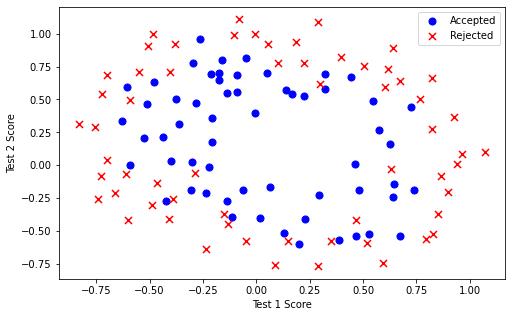

In [76]:
def plot_data():
    positive = data2[data2['Accepted'].isin([1])]
    negative = data2[data2['Accepted'].isin([0])]

    fig, ax = plt.subplots(figsize=(8,5))
    ax.scatter(positive['Test 1'], positive['Test 2'], s=50, c='b', marker='o', label='Accepted')
    ax.scatter(negative['Test 1'], negative['Test 2'], s=50, c='r', marker='x', label='Rejected')
    ax.legend()
    ax.set_xlabel('Test 1 Score')
    ax.set_ylabel('Test 2 Score')
    
plot_data()

注意到其中的正负两类数据并没有线性的决策界限。因此直接用logistic回归在这个数据集上并不能表现良好，因为它只能用来寻找一个线性的决策边界。

所以接下会提到一个新的方法。

## 2.2 Feature mapping
一个拟合数据的更好的方法是从每个数据点创建更多的特征。

我们将把这些特征映射到所有的x1和x2的多项式项上，直到第六次幂。

In [77]:
def feature_mapping(x1, x2, power):
    data = {}
    for i in np.arange(power + 1):
        for p in np.arange(i + 1):
            data["f{}{}".format(i - p, p)] = np.power(x1, i - p) * np.power(x2, p)

    return pd.DataFrame(data)

In [78]:
x1 = data2['Test 1'].values
x2 = data2['Test 2'].values

In [79]:
features = feature_mapping(x1, x2, 6)

In [80]:
features.head()

,f00,f10,f01,f20,f11,f02,f30,f21,f12,f03,...,f23,f14,f05,f60,f51,f42,f33,f24,f15,f06
0,1.0,0.051267,0.69956,0.002628,0.035864,0.489384,0.000135,0.001839,0.025089,0.342354,...,0.000900,0.012278,0.167542,1.815630e-08,2.477505e-07,0.000003,0.000046,0.000629,0.008589,0.117206
1,1.0,-0.092742,0.68494,0.008601,-0.063523,0.469143,-0.000798,0.005891,-0.043509,0.321335,...,0.002764,-0.020412,0.150752,6.362953e-07,-4.699318e-06,0.000035,-0.000256,0.001893,-0.013981,0.103256
2,1.0,-0.213710,0.69225,0.045672,-0.147941,0.479210,-0.009761,0.031616,-0.102412,0.331733,...,0.015151,-0.049077,0.158970,9.526844e-05,-3.085938e-04,0.001000,-0.003238,0.010488,-0.033973,0.110047
3,1.0,-0.375000,0.50219,0.140625,-0.188321,0.252195,-0.052734,0.070620,-0.094573,0.126650,...,0.017810,-0.023851,0.031940,2.780914e-03,-3.724126e-03,0.004987,-0.006679,0.008944,-0.011978,0.016040
4,1.0,-0.513250,0.46564,0.263426,-0.238990,0.216821,-0.135203,0.122661,-0.111283,0.100960,...,0.026596,-0.024128,0.021890,1.827990e-02,-1.658422e-02,0.015046,-0.013650,0.012384,-0.011235,0.010193


## 2.3 正则化代价函数

In [81]:
X = features
y = data2['Accepted'].values

theta = np.zeros(X.shape[1])
X.shape, y.shape, theta.shape

((118, 28), (118,), (28,))

In [82]:
def cost_reg(theta, X, y, l=1):
    # 不惩罚第一项
    _theta = theta[1: ]
    reg = (l / (2 * len(X))) *(_theta @ _theta)  # _theta@_theta == inner product
    
    return cost(theta, X, y) + reg

In [83]:
cost_reg(theta, X, y, l=1)

0.6931471805599454

## 2.4 正则化梯度

In [84]:
def gradient_reg(theta, X, y, l=1):
    reg = (1 / len(X)) * theta
    reg[0] = 0  
    return gradient(theta, X, y) + reg

In [85]:
gradient_reg(theta, X, y, 1)

f00    0.008475
f10    0.018788
f01    0.000078
f20    0.050345
f11    0.011501
f02    0.037665
f30    0.018356
f21    0.007324
f12    0.008192
f03    0.023476
f40    0.039349
f31    0.002239
f22    0.012860
f13    0.003096
f04    0.039303
f50    0.019971
f41    0.004330
f32    0.003386
f23    0.005838
f14    0.004476
f05    0.031008
f60    0.031031
f51    0.001097
f42    0.006316
f33    0.000409
f24    0.007265
f15    0.001376
f06    0.038794
dtype: float64

## 2.5 学习参数

In [86]:
result2 = opt.fmin_tnc(func=cost_reg, x0=theta, fprime=gradient_reg, args=(X, y, 2))
result2

(array([ 1.02253315,  0.56283985,  1.13465478, -1.78529789, -0.6653923 ,
        -1.01863216,  0.13957089, -0.29358932, -0.30102319, -0.08324324,
        -1.27205989, -0.06137387, -0.53996517, -0.17881824, -0.94198754,
        -0.1405479 , -0.17736675, -0.07697372, -0.22918946, -0.21349686,
        -0.37205222, -0.86417683,  0.00890078, -0.26795962, -0.00362253,
        -0.28315241, -0.07321604, -0.75992493]),
 57,
 1)

我们还可以使用高级Python库scikit-learn来解决这个问题。

In [87]:
from sklearn import linear_model#调用sklearn的线性回归包
model = linear_model.LogisticRegression(penalty='l2', C=1.0, solver='liblinear')
model.fit(X, y.ravel())

LogisticRegression(solver='liblinear')

In [88]:
model.score(X, y)

0.8305084745762712

## 2.6 评估逻辑回归

In [89]:
final_theta = result2[0]
predictions = predict(final_theta, X)
correct = [1 if a==b else 0 for (a, b) in zip(predictions, y)]
accuracy = sum(correct) / len(correct)
accuracy

0.8050847457627118

或者用skearn中的方法来评估结果

In [90]:
from sklearn.metrics import classification_report

print(classification_report(y, predictions))

              precision    recall  f1-score   support

           0       0.85      0.75      0.80        60
           1       0.77      0.86      0.81        58

    accuracy                           0.81       118
   macro avg       0.81      0.81      0.80       118
weighted avg       0.81      0.81      0.80       118



## 2.7 决策边界

In [91]:
x = np.linspace(-1, 1.5, 250)
xx, yy = np.meshgrid(x, x)

(-0.8, 1.2)

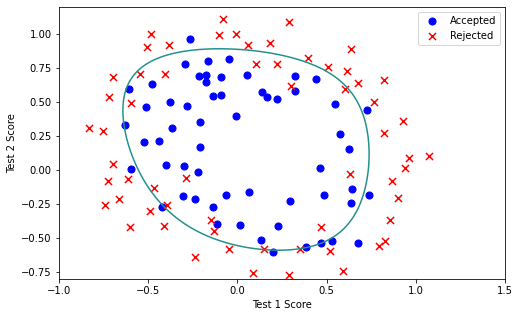

In [92]:
z = feature_mapping(xx.ravel(), yy.ravel(), 6).values
z = z @ final_theta
z = z.reshape(xx.shape)

plot_data()
plt.contour(xx, yy, z, 0)
plt.ylim(-.8, 1.2)